In [1]:
from monai.utils import set_determinism

from monai.metrics import DiceMetric, compute_meandice
from monai.losses import DiceLoss
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
import torch
import os
import sys
import yaml
import random
import glob
from pathlib import Path
from tqdm import tqdm
import torch
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import (
    AsDiscrete,
    Compose,
    EnsureType,
)
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/lobe_seg")
import MetricLogger
from dataloader import train_dataloader, val_dataloader
from models import unet256, unet512
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools")
import func.vis.vis as vis

In [7]:
def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config
CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
config_id = "test0327"
config = load_config(f"Config_{config_id}.YAML", CONFIG_DIR)

In [8]:
# unwrap directory paths
MODEL_DIR = os.path.join(config["model_dir"], config_id)
CHECKPOINT_DIR = os.path.join(config["checkpoint_dir"], "0327unet512")
LOG_DIR = os.path.join(config["log_dir"], config_id)
DATA_DIR = config["data_dir"]

# Set randomness
set_determinism(seed=config["random_seed"])
random.seed(config["random_seed"])

# Make paths
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(LOG_DIR).mkdir(parents=True, exist_ok=True)
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

# Logger
# logger = MetricLogger.MetricLogger(config, config_id)
writer = SummaryWriter(log_dir=LOG_DIR)

# Load data
images = sorted(glob.glob(os.path.join(DATA_DIR, config["image_type"])))
# limit sample size if specified
if config["sample_size"]:
    images = random.sample(images, config["sample_size"])
# split dataset into train and validation
val_size = int(len(images) * config["val_ratio"])
random.shuffle(images)
val_images, train_images = images[:val_size], images[val_size:]
# get dataloaders
train_loader = train_dataloader(config, train_images)
val_loader = val_dataloader(config, val_images)

# LABEL_SHAPE = (512, 512, 320)  # All labels have this shape, but input shapes vary

# Initialize Model, Loss, and Optimizer
device = torch.device("cuda:0")

if config["model"] == 'unet512':
    model = unet512(6).to(device)
else:
    model = unet256(6).to(device)
loss_function = DiceLoss(include_background=config["include_bg_loss"], to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
dice_metric = DiceMetric(include_background=config["include_bg_loss"], reduction="mean")
start_epoch = 0

# Resume training from checkpoint if indicated
if config["checkpoint"]:
    print(f"Resuming training of {config_id} from {config['checkpoint']}")
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, config["checkpoint"]))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

# Finetune pretrained model if indicated
if config["pretrained"]:
    print(f"Fine tuning model from {config['pretrained']}")
    pretrained = torch.load(config['pretrained'])
    model.load_state_dict(pretrained)

Training sample size: 105
Validation sample size: 11
Resuming training of test0327 from epoch300.tar


--------------------
epoch 1/1


  0%|                                                                                                          | 0/8 [00:00<?, ?it/s]

(array([0., 1.], dtype=float32), array([413133, 471603]))
(array([0., 1.], dtype=float32), array([401766, 482970]))
loss 0.616631031036377
val agg tensor([[0.9673, 0.9338,    nan,    nan,    nan],
        [0.9724, 0.9440,    nan,    nan,    nan],
        [   nan,    nan,    nan, 0.8844, 0.9198],
        [0.0382,    nan, 0.9797, 0.0870, 0.9512]], device='cuda:0')
torch mean 0.767764687538147


  0%|                                                                                                          | 0/8 [00:15<?, ?it/s]


val agg tensor([[0.9673, 0.9338, 0.0000, 0.0000, 0.0000],
        [0.9724, 0.9440, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8844, 0.9198],
        [0.0382, 0.0000, 0.9797, 0.0870, 0.9512]], device='cuda:0')
val agg tensor([0.3839], device='cuda:0')
val agg 0.3838823437690735
epoch loss 0.616631031036377
epoch_dice 0.831202507019043
epoch 1 average loss: 0.6166


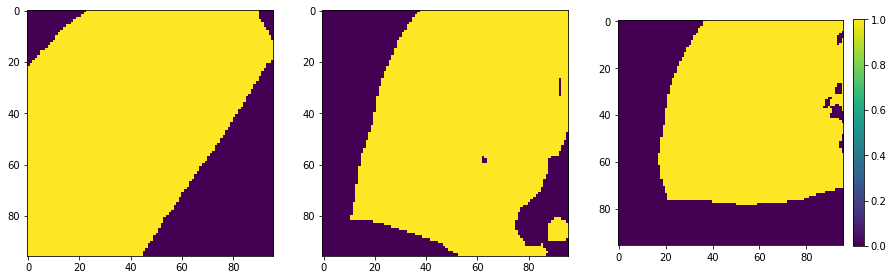

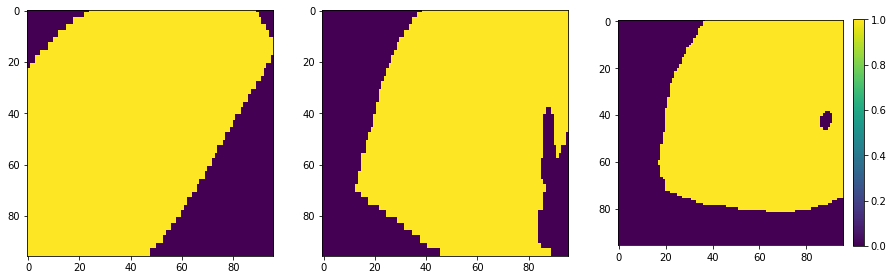

In [77]:
# Training protocol
best_metric = -1
best_metric_epoch = -1
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=6)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=6)])
start_epoch, epochs = (0,config["epochs"])
val_metric = dice_metric
val_metric.reset()

for epoch in range(start_epoch, epochs):
    print("-" * 20)
    print(f"epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch in tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch["image"].to(device),
            batch["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss and dice over epoch
        epoch_loss += loss.item()
        outputs = [post_pred(i) for i in decollate_batch(outputs)]
        labels = [post_label(i) for i in decollate_batch(labels)]
        output_img = outputs[0][1,:,:,:].detach().cpu().numpy()
        label_img = labels[0][1,:,:,:].detach().cpu().numpy()
        print(np.unique(output_img, return_counts=True))
        print(np.unique(label_img, return_counts=True))
        vis.showslice(output_img, 50,50,50)
        vis.showslice(label_img, 50,50,50)
        
        val_metric(y_pred=outputs, y=labels)
        print(f"loss {loss}")
        # print(f"val item {val_metric.aggregate().item()}")
        print(f"val agg {val_metric.get_buffer()}")
        print(f"torch mean {torch.nanmean(val_metric.get_buffer())}")
        

        # print(
        #     f"{step}/{len(train_loader.dataset) // train_loader.batch_size}, "
        #     f"train_loss: {loss.item():.4f}")
        break

    # loss and dice of training
    epoch_loss /= step
    epoch_dice = val_metric.aggregate().item()
    print(f"val agg {val_metric.get_buffer()}")
    print(f"val agg {val_metric.aggregate()}")
    print(f"val agg {val_metric.aggregate().item()}")
    val_metric.reset()

    # logging
    # logger.log("loss", (epoch + 1, epoch_loss))
    # logger.log("dice", (epoch + 1, epoch_dice))
    # writer.add_scalar('Loss/train', epoch_loss, epoch + 1)
    # writer.add_scalar('Dice/train', epoch_dice, epoch + 1)
    print(f"epoch loss {epoch_loss}")
    print(f"epoch_dice {epoch_dice}")
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

Training dice metric is computing incorrectly because the dice is not aggregated on a patch that does not have that class. As a result, only dices are calculated on patches with the class present.

NameError: name 'val_metric' is not defined

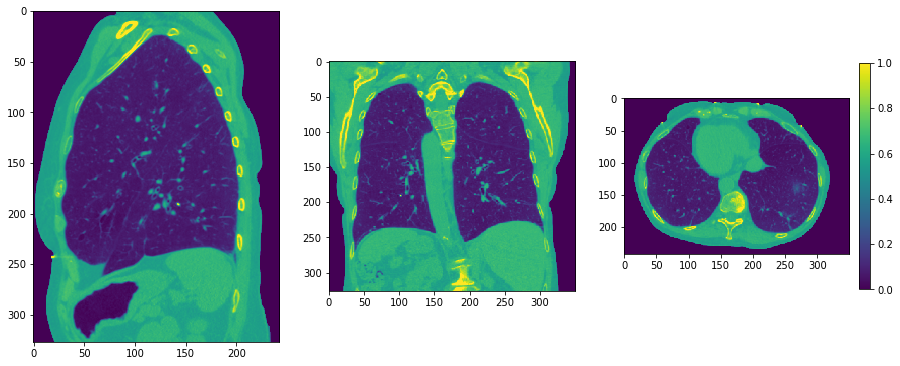

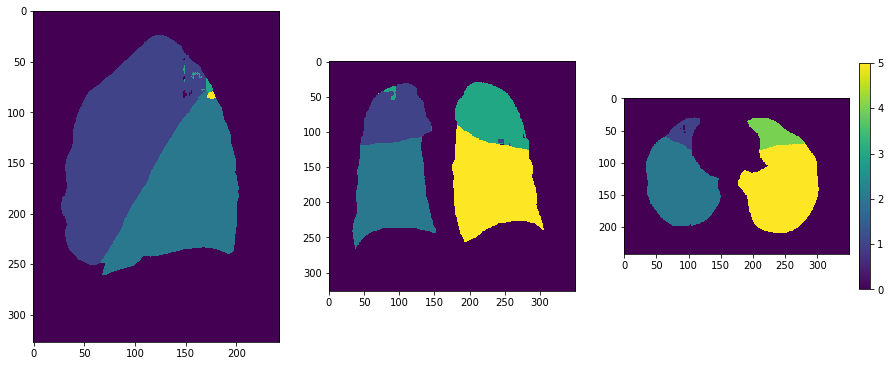

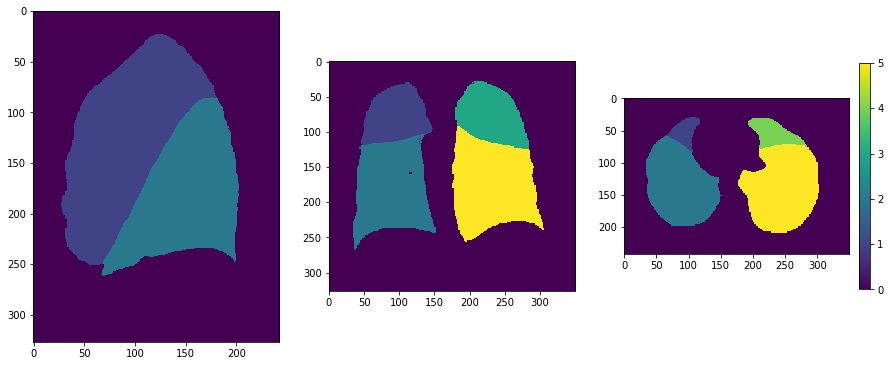

In [10]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=6)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=6)])
model.eval()

val_loss = 0
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = config["crop_shape"]
        sw_batch_size = 4
        # Run over the input image with a sliding window, run inference on each fragment and then aggregate to get the overall result.
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        loss = loss_function(val_outputs, val_labels)
        np_input = val_data["image"][0, 0, :, :, :].detach().cpu().numpy()
        np_output = torch.argmax(val_outputs, dim=1)[0,:,:,:].detach().cpu().numpy()
        np_label = val_data["label"][0, 0, :, :, :].detach().cpu().numpy()
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        
        # np_output = val_outputs[0][0, :, :, :].detach().cpu().numpy()
        # np_label = val_labels[0][0, :, :, :].detach().cpu().numpy()
        vis.showslice(np_input, 100,100,100)
        vis.showslice(np_output, 100,100,100)
        vis.showslice(np_label, 100,100,100)
        
        # compute loss and dice for current iter
        val_loss += loss.item()
        val_metric(y_pred=val_outputs, y=val_labels)
        break

# total loss and dice over validation set
val_loss /= len(val_loader.dataset)
val_dice = val_metric.aggregate().item()
val_metric.reset()
print(val_loss)
print(val_dice)

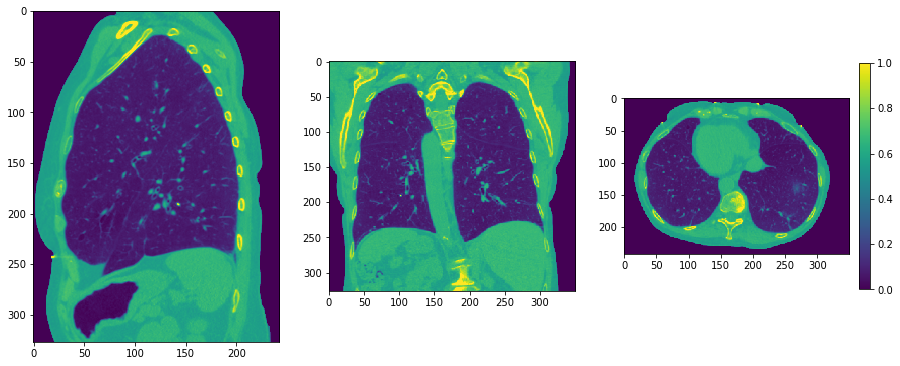

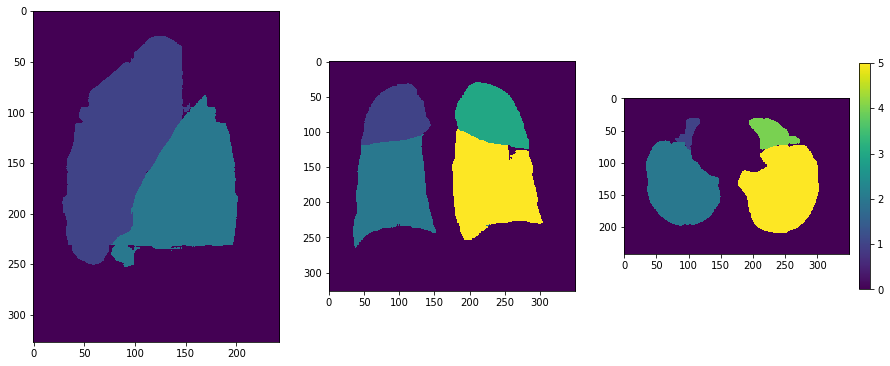

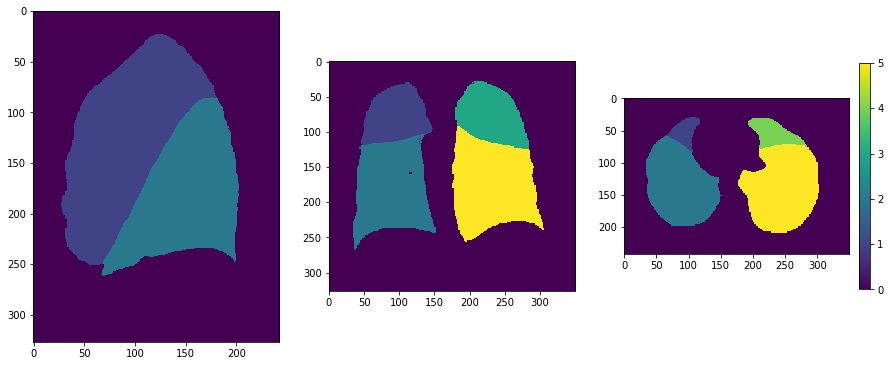

In [9]:
vis.showslice(np_input, 100,100,100)
vis.showslice(np_output, 100,100,100)
vis.showslice(np_label, 100,100,100)